# **🧬 MPEG-G Microbiome Classification**
## **Introduction**

The human microbiome—an intricate community of microorganisms across different body sites—plays a key role in our health. These microbial populations vary widely by location, such as the gut, skin, mouth, or nasal passages. Accurately identifying where a microbiome sample comes from can enhance our understanding of disease mechanisms, immunity, and personalized treatment.

## **Business Understanding**
This project aims to build a machine learning model that classifies microbiome samples by body site using 16S rRNA sequence data stored in MPEG-G format, along with metadata and cytokine profiles when available. Beyond traditional modeling, we also explore federated learning to allow collaborative training across institutions without compromising data privacy.
### **1. Business Problem**
The core problem this project addresses is the development of an accurate and efficient classification model that can determine the body site from which a microbiome sample originates
### **2.Business Objective**
  - Accelerate diagnostic capabilities by developing a reliable machine learning model to classify biological samples based on their sequencing data, enabling faster identification of sample origins.

  -  Support clinical decision-making by providing accurate predictions that can guide further laboratory analysis, reducing reliance on lengthy and expensive traditional tests.

  - Enhance research efficiency through automation of sample classification, freeing up specialist time for higher-value tasks such as investigating novel biomarkers.

  - Enable scalable analysis of large volumes of genomic data without proportional increases in manpower or cost, making population-scale microbiome studies more feasible.

  - Strengthen early detection and prevention strategies by improving the ability to monitor and track microbiome shifts linked to health conditions or environmental changes.

  - Demonstrate the potential of AI-driven microbiome analytics in supporting public health initiatives, such as outbreak tracing or gut health research, by delivering actionable classification results.
  
### **3. Stakeholders**
  - Bioinformatics researchers
  - Clinical microbiologists
  - Genomics data scientists

## **Data Understanding**

This project uses data from the **MPEG-G Microbiome Classification Challenge** on Zindi, consisting of 2,901 training and 1,068 test samples. The core data includes MPEG-G compressed 16S rRNA sequences (.mgb files), decoded into .fastq.gz format for analysis. These are paired with tabular metadata: Train.csv (with body site labels), Test.csv (without labels), Train_Subjects.csv (age, sex, insulin sensitivity), and optionally cytokine_profiles.csv (immune markers).

Each sample represents a microbiome collected from one of four body sites: Nasal, Mouth, Skin, or Stool. The goal is to classify the origin of each sample using engineered features from sequences and participant metadata. The dataset is stratified by participant and insulin sensitivity, ensuring a balanced distribution. This project is unique in combining privacy-aware federated learning with real-world genomic compression (MPEG-G) for medical ML applications.

## **Data Preparation**
To prepare the data for modeling, we began by decoding the .mgb (MPEG-G) files into .fastq.gz format using Docker and the open-source Genie tool, which is tailored for handling MPEG-G genomic data. Docker ensures a consistent environment for running Genie across different systems, avoiding dependency conflicts. The decoding process was necessary because most bioinformatics tools work with standard formats like FASTQ. Once decoded, the .fastq.gz files are organized and processed to extract read-level features such as read length, nucleotide distribution, and GC content, which will serve as input for machine learning models.


### **1. Decompress MPEG-G Files**

In [1]:
# %pip install Bio (provides essential tools for parsing, analyzing, and processing biological sequence data, especially FASTQ files)

In [2]:
 # Import packages
"""
import os
import zipfile
import subprocess
import shutil
from Bio import SeqIO
from collections import Counter
"""

'\nimport os\nimport zipfile\nimport subprocess\nimport shutil\nfrom Bio import SeqIO\nfrom collections import Counter\n'

In [3]:
# Extract Train and Test files (mpeg zipped files)
"""
print(os.listdir('.')) #( lists all thefiles and directories in the current working directory, and prints them files and directories in the current working directory, and prints them)
 # Define zip files and corresponding output directories
zip_targets = {
    r"C:\\Users\\JUDAH\\Downloads\\TrainFiles.zip": './train',
    r"C:\\Users\\JUDAH\\Downloads\\TestFiles.zip": './test'
}

for zip_path, extract_to in zip_targets.items():
    # Create the output directory if it doesn't exist
    os.makedirs(extract_to, exist_ok=True)

    try:
        # Use shutil to extract
        shutil.unpack_archive(zip_path, extract_to, format='zip')
        print(f"✅ Successfully extracted {zip_path} to ./{extract_to}/")
    except Exception as e:
        print(f"❌ Failed to extract {zip_path}: {e}")
"""
# Output
"""
✅ Successfully extracted C:\\Users\\JUDAH\\Downloads\\TrainFiles.zip to ././train/
✅ Successfully extracted C:\\Users\\JUDAH\\Downloads\\TestFiles.zip to ././test/
"""


'\n✅ Successfully extracted C:\\Users\\JUDAH\\Downloads\\TrainFiles.zip to ././train/\n✅ Successfully extracted C:\\Users\\JUDAH\\Downloads\\TestFiles.zip to ././test/\n'

In [4]:
# A function to decode the mgb files
# Set base directories
"""
notebook_dir = os.getcwd()
container_dir = "/data"
"""
# Function to decode all `.mgb` files in their respective folder
"""
def decode_all_mgb_in_folder(folder_name):
    host_dir = os.path.join(notebook_dir, folder_name)

    for mgb_filename in os.listdir(host_dir):
        if not mgb_filename.endswith(".mgb"):
            continue

        mgb_path = os.path.join(host_dir, mgb_filename)
        mgb_filename_no_ext = os.path.splitext(mgb_filename)[0]
        fastq_path = os.path.join(host_dir, f"{mgb_filename_no_ext}.fastq")
        fastq_gz_path = f"{fastq_path}.gz"

        command = [
            "docker", "run", "--rm",
            "-v", f"{host_dir}:{container_dir}",
            "muefab/genie:latest", "run",
            "-f",
            "-i", f"{container_dir}/{mgb_filename}",
            "-o", f"{container_dir}/{mgb_filename_no_ext}.fastq"
        ]

        subprocess.run(command, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

        if not os.path.exists(fastq_path):
            print(f"[Error] FASTQ not created: {mgb_filename}")
            continue

        try:
            with open(fastq_path, "rb") as f_in, gzip.open(fastq_gz_path, "wb") as f_out:
                shutil.copyfileobj(f_in, f_out)
        except Exception as e:
            print(f"[Error] Compression failed: {mgb_filename} - {str(e)}")
            continue

        os.remove(mgb_path)# delete the original `.mgb` file
        os.remove(fastq_path) #delete the uncompressed FASTQ file

        print(f"[OK] {mgb_filename} → {os.path.basename(fastq_gz_path)}")

        """

'\ndef decode_all_mgb_in_folder(folder_name):\n    host_dir = os.path.join(notebook_dir, folder_name)\n\n    for mgb_filename in os.listdir(host_dir):\n        if not mgb_filename.endswith(".mgb"):\n            continue\n\n        mgb_path = os.path.join(host_dir, mgb_filename)\n        mgb_filename_no_ext = os.path.splitext(mgb_filename)[0]\n        fastq_path = os.path.join(host_dir, f"{mgb_filename_no_ext}.fastq")\n        fastq_gz_path = f"{fastq_path}.gz"\n\n        command = [\n            "docker", "run", "--rm",\n            "-v", f"{host_dir}:{container_dir}",\n            "muefab/genie:latest", "run",\n            "-f",\n            "-i", f"{container_dir}/{mgb_filename}",\n            "-o", f"{container_dir}/{mgb_filename_no_ext}.fastq"\n        ]\n\n        subprocess.run(command, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)\n\n        if not os.path.exists(fastq_path):\n            print(f"[Error] FASTQ not created: {mgb_filename}")\n            continue\n\n      

In [5]:
# Use function on the mpg files
"""
decode_all_mgb_in_folder(r"C:\\Users\\JUDAH\\Desktop\\Mircobiome MPEG\\train\\TrainFiles")
decode_all_mgb_in_folder(r"C:\\Users\\JUDAH\\Desktop\\Mircobiome MPEG\\test\\TestFiles")
"""
# Sample Output
"""
[OK] ID_AAFNOT.mgb → ID_AAFNOT.fastq.gz
[OK] ID_AAXPTO.mgb → ID_AAXPTO.fastq.gz
[OK] ID_AAYKAN.mgb → ID_AAYKAN.fastq.gz
[OK] ID_ABEZNS.mgb → ID_ABEZNS.fastq.gz
[OK] ID_ABFFLP.mgb → ID_ABFFLP.fastq.gz
[OK] ID_ABFQPG.mgb → ID_ABFQPG.fastq.gz
[OK] ID_ABMLPB.mgb → ID_ABMLPB.fastq.gz
[OK] ID_ABOEMW.mgb → ID_ABOEMW.fastq.gz
[OK] ID_ABRMNZ.mgb → ID_ABRMNZ.fastq.gz
"""

'\n[OK] ID_AAFNOT.mgb → ID_AAFNOT.fastq.gz\n[OK] ID_AAXPTO.mgb → ID_AAXPTO.fastq.gz\n[OK] ID_AAYKAN.mgb → ID_AAYKAN.fastq.gz\n[OK] ID_ABEZNS.mgb → ID_ABEZNS.fastq.gz\n[OK] ID_ABFFLP.mgb → ID_ABFFLP.fastq.gz\n[OK] ID_ABFQPG.mgb → ID_ABFQPG.fastq.gz\n[OK] ID_ABMLPB.mgb → ID_ABMLPB.fastq.gz\n[OK] ID_ABOEMW.mgb → ID_ABOEMW.fastq.gz\n[OK] ID_ABRMNZ.mgb → ID_ABRMNZ.fastq.gz\n'

### **2. Exploratory Data Analysis**



In [6]:
#%pip install Bio 

####  **Load Datasets**

In [7]:
# Import packages
import os
import zipfile
import subprocess
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import time
import gzip
from Bio import SeqIO
from tqdm import tqdm
import shap
from Bio import SeqIO
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score ,roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Errors ignore
import warnings
warnings.filterwarnings('ignore')

In [8]:
# Read in CSV files
train_df = pd.read_csv(r".\Other Files\Train.csv")
test_df = pd.read_csv(r".\Other Files\Test.csv")
train_subjects_df = pd.read_csv(r".\Other Files\Train_Subjects.csv") 
ss = pd.read_csv(r".\Other Files\SampleSubmission.csv")
cytokine_df = pd.read_csv(r".\Other Files\cytokine_profiles.csv")

# Merge training data
train_full_df = pd.merge(train_df, train_subjects_df, on='SubjectID', how='left')
train_full_df = pd.merge(train_full_df, cytokine_df, on='SampleID', how='left')

print("Training data shape after merge:", train_full_df.shape)
print("Test data shape after merge:", test_df.shape)

train_full_df.head()


Training data shape after merge: (2901, 92)
Test data shape after merge: (1068, 1)


,filename,SampleType,SubjectID,SampleID,FPG_Mean,FPG_class,IRIS,SSPG,FPG,SSPG.Date,...,ENA78,CHEX1,CHEX2,CHEX3,CHEX4,CollectionDate,CL1,CL2,CL3,CL4
0,ID_LETPJN.mgb,Stool,Subject_BCUNIB,Sample_AFTIWE,1.063333,Prediabetes,Unknown,NaN,NaN,NaN,...,260.803223,10348.221434,615.135794,1145.764405,15.090773,1/28/16,NaN,NaN,NaN,Healthy
1,ID_NTDGIW.mgb,Stool,Subject_UDAXIH,Sample_JQJVNK,1.274432,Diabetes,IS,91.5,131.75,8/7/14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ID_ZISBMF.mgb,Nasal,Subject_VRKADI,Sample_YJWGWW,0.899545,Normal,IR,220.0,95.00,12/18/12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ID_MDCVXU.mgb,Nasal,Subject_HIFZWD,Sample_VKEHZP,0.800000,Normal,IR,235.0,100.00,5/30/12,...,330.895379,10184.682491,660.826952,1176.694165,15.096921,10/24/14,D3,flu,Imz_Middle,Imz
4,ID_SWAMNY.mgb,Stool,Subject_VGLNCV,Sample_NTDTEQ,0.882667,Normal,IR,162.0,99.00,10/21/13,...,304.064072,9424.953170,741.731826,1259.429265,14.277080,2/20/15,NaN,NaN,NaN,Healthy


In [9]:
#Check for missing values
print(train_full_df.isnull().sum())


filename             0
SampleType           0
SubjectID            0
SampleID             0
FPG_Mean             0
                  ... 
CollectionDate     919
CL1               2206
CL2               2603
CL3               2247
CL4                919
Length: 92, dtype: int64


In [10]:
# Drop Columns with more than 50% missing values
train_full_df.drop(columns=['CL1', 'CL2', 'CL3', 'CL4'], inplace=True)


In [11]:
#Drop collectionDate 
train_full_df.drop(columns=['CollectionDate'], inplace=True)


#### **Explore the train, test & subject information**

In [12]:
# Check top 5 rows of the training data
train_df.head()

,filename,SampleType,SubjectID,SampleID
0,ID_LETPJN.mgb,Stool,Subject_BCUNIB,Sample_AFTIWE
1,ID_NTDGIW.mgb,Stool,Subject_UDAXIH,Sample_JQJVNK
2,ID_ZISBMF.mgb,Nasal,Subject_VRKADI,Sample_YJWGWW
3,ID_MDCVXU.mgb,Nasal,Subject_HIFZWD,Sample_VKEHZP
4,ID_SWAMNY.mgb,Stool,Subject_VGLNCV,Sample_NTDTEQ


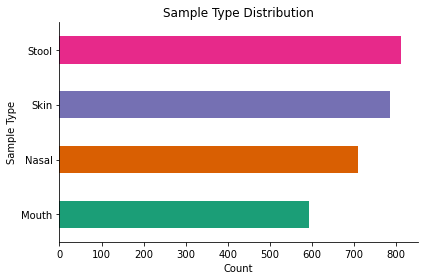

In [13]:
# Visualization of sample type distribution
train_df.groupby('SampleType').size().plot(kind='barh', color=sns.color_palette('Dark2'))
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)
plt.xlabel('Count')
plt.ylabel('Sample Type')
plt.title('Sample Type Distribution')
plt.tight_layout()
plt.show()


In [14]:
print(f"Number of unique subjects in train_df: {train_df['SubjectID'].nunique()}")
print(f"Number of unique SampleType in train_df: {train_df['SampleType'].nunique()}")
print(f"Number of unique Files in train_df: {train_df['filename'].nunique()}")
print(f"Unique values in SampleType: {train_df['SampleType'].unique()}")

train_df.head()

Number of unique subjects in train_df: 66
Number of unique SampleType in train_df: 4
Number of unique Files in train_df: 2901
Unique values in SampleType: ['Stool' 'Nasal' 'Mouth' 'Skin']


,filename,SampleType,SubjectID,SampleID
0,ID_LETPJN.mgb,Stool,Subject_BCUNIB,Sample_AFTIWE
1,ID_NTDGIW.mgb,Stool,Subject_UDAXIH,Sample_JQJVNK
2,ID_ZISBMF.mgb,Nasal,Subject_VRKADI,Sample_YJWGWW
3,ID_MDCVXU.mgb,Nasal,Subject_HIFZWD,Sample_VKEHZP
4,ID_SWAMNY.mgb,Stool,Subject_VGLNCV,Sample_NTDTEQ


Average number of files per SubjectID in train_df: 43.95


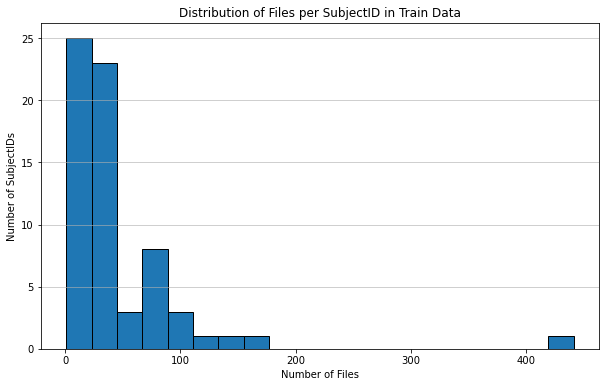

In [15]:
# Visualization of the average number of files per SubjectID

files_per_subject = train_df.groupby('SubjectID')['filename'].count().reset_index()
files_per_subject = files_per_subject.rename(columns={'filename': 'FileCount'})
average_files_per_subject = files_per_subject['FileCount'].mean()
print(f"Average number of files per SubjectID in train_df: {average_files_per_subject:.2f}")
# Plot
plt.figure(figsize=(10, 6))
plt.hist(files_per_subject['FileCount'], bins=20, edgecolor='black')
plt.title('Distribution of Files per SubjectID in Train Data')
plt.xlabel('Number of Files')
plt.ylabel('Number of SubjectIDs')
plt.grid(axis='y', alpha=0.75)
plt.show()

> . The plot above shows the number of files each subject had. In that case, when a subject is included, **four samples** are taken. As seen, most subjects overall had **20-25 samples** taken over the research period; however, some had more than 25 samples taken, like the few subjects who had more than **+ 400 samples** taken.These extreme cases may represent participants who were followed up more intensively, perhaps due to **medical interest** or their **availability**.This also highlights the dedication of these participants and the importance of the research in capturing detailed, longitudinal microbiome data.

In [16]:
# Check for unique files in test_df and top 5 rows
print(f"Number of unique Files in test_df: {test_df['filename'].nunique()}")
test_df.head()

Number of unique Files in test_df: 1068


,filename
0,ID_YBNOYC.mgb
1,ID_HPVLUO.mgb
2,ID_DQGGYD.mgb
3,ID_XZBUJB.mgb
4,ID_KRPYRQ.mgb


In [17]:
# Check top 5 rows of train_subjects_df
train_subjects_df.head()

,SubjectID,FPG_Mean,FPG_class,IRIS,SSPG,FPG,SSPG.Date,Class,Gender,Ethnicity,Adj.age,BMI,OGTT,OGTT_Class,Longitudinal.HbA1C.Group,A1C_Class,Family
0,Subject_UDAXIH,1.274432,Diabetes,IS,91.5,131.75,8/7/14,Diabetic,M,C,59.48,21.47,2.245,Diabetes,6. Variable Diabetic-PreDM (n = 8),6.VDP,NaN
1,Subject_NHOSIZ,0.915833,Normal,Unknown,NaN,NaN,NaN,Prediabetic,M,C,61.17,27.06,1.005,Normal,3. PreDM-to-Normal (n = 10),3.PN,NaN
2,Subject_AYZFWN,0.952000,Normal,Unknown,NaN,NaN,NaN,Prediabetic,F,A,56.22,30.61,NaN,NaN,1. Normal (n = 51),1.Normal,NaN
3,Subject_KIEGYK,1.160000,Prediabetes,Unknown,NaN,NaN,NaN,Prediabetic,M,C,49.18,23.22,NaN,NaN,1. Normal (n = 51),1.Normal,NaN
4,Subject_CBVHYJ,0.880000,Normal,Unknown,NaN,NaN,NaN,Control,F,C,46.04,25.26,0.930,Normal,1. Normal (n = 51),1.Normal,NaN


In [18]:
# Check the description of train_subjects_df
train_subjects_df.describe()

,FPG_Mean,SSPG,FPG,Adj.age,BMI,OGTT
count,66.000000,44.000000,44.000000,66.000000,66.000000,56.000000
mean,0.940581,149.815000,99.937500,54.976212,27.895000,1.371667
std,0.117552,68.402027,11.397818,10.315599,4.334436,0.455184
min,0.756000,40.000000,78.000000,29.180000,19.100000,0.640000
25%,0.870000,90.375000,94.750000,49.772500,25.040000,1.089167
50%,0.902557,156.935000,97.500000,55.300000,27.195000,1.250000
75%,1.017500,220.000000,101.937500,61.747500,30.092500,1.533125
max,1.274432,274.000000,138.000000,75.230000,40.830000,3.087500


###  **Explore the fastq files**

In [19]:
# function to extract features from FASTQ files
def extract_fastq_features(file_path):
    features = {
        'filename': os.path.basename(file_path).replace('.fastq.gz', '.mgb'),
        'avg_read_length': 0,
        'gc_content': 0,
        'n_content': 0,
        'read_count': 0
    }
    total_length, total_gc, total_n, read_count = 0, 0, 0, 0
    try:
        with gzip.open(file_path, 'rt') as handle:
            for record in SeqIO.parse(handle, 'fastq'):
                seq = str(record.seq)
                total_length += len(seq)
                total_gc += seq.count('G') + seq.count('C')
                total_n += seq.count('N')
                read_count += 1
        if read_count > 0:
            features['avg_read_length'] = total_length / read_count
            features['gc_content'] = (total_gc / total_length) * 100 if total_length > 0 else 0
            features['n_content'] = (total_n / total_length) * 100 if total_length > 0 else 0
            features['read_count'] = read_count
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
    return features

train_files_path =(r'.\train\TrainFiles')
test_files_path = (r'.\test\TestFiles')
train_fastq_files = [os.path.join(train_files_path, f) for f in os.listdir(train_files_path) if f.endswith('.fastq.gz')]
test_fastq_files = [os.path.join(test_files_path, f) for f in os.listdir(test_files_path) if f.endswith('.fastq.gz')]

train_features = [extract_fastq_features(f) for f in tqdm(train_fastq_files, desc='Processing Train Files')]
test_features = [extract_fastq_features(f) for f in tqdm(test_fastq_files, desc='Processing Test Files')]

train_features_df = pd.DataFrame(train_features)
test_features_df = pd.DataFrame(test_features)

train_features_df.head()

Processing Test Files: 100%|██████████| 1068/1068 [1:06:38<00:00,  3.74s/it]


,filename,avg_read_length,gc_content,n_content,read_count
0,ID_AAFNOT.mgb,124.5,55.262863,0.0,42840
1,ID_AAXPTO.mgb,400.0,53.985332,0.0,42814
2,ID_AAYKAN.mgb,400.0,54.331387,0.0,21794
3,ID_ABEZNS.mgb,124.5,52.918782,0.0,448014
4,ID_ABFFLP.mgb,400.0,55.812463,0.0,15173


In [20]:
print(test_features_df.columns)

Index(['filename', 'avg_read_length', 'gc_content', 'n_content', 'read_count'], dtype='object')


In [ ]:
# Combine sequence features with metadata
train_processed_df = pd.merge(train_full_df, train_features_df, on='filename', how='left')
test_processed_df = pd.merge(test_df, test_features_df, on='filename', how='left')

print("Training data shape after adding sequence features:", train_processed_df.shape)
print("Test data shape after adding sequence features:", test_processed_df.shape)

test_processed_df.head()

Training data shape after adding sequence features: (2901, 91)
Test data shape after adding sequence features: (1068, 5)


,filename,SampleType,SubjectID,SampleID,FPG_Mean,FPG_class,IRIS,SSPG,FPG,SSPG.Date,...,CD40L,ENA78,CHEX1,CHEX2,CHEX3,CHEX4,avg_read_length,gc_content,n_content,read_count
0,ID_LETPJN.mgb,Stool,Subject_BCUNIB,Sample_AFTIWE,1.063333,Prediabetes,Unknown,NaN,NaN,NaN,...,282.210259,260.803223,10348.221434,615.135794,1145.764405,15.090773,400.0,52.814633,0.0,21599.0
1,ID_NTDGIW.mgb,Stool,Subject_UDAXIH,Sample_JQJVNK,1.274432,Diabetes,IS,91.5,131.75,8/7/14,...,NaN,NaN,NaN,NaN,NaN,NaN,400.0,53.574193,0.0,20295.0
2,ID_ZISBMF.mgb,Nasal,Subject_VRKADI,Sample_YJWGWW,0.899545,Normal,IR,220.0,95.00,12/18/12,...,NaN,NaN,NaN,NaN,NaN,NaN,400.0,55.170314,0.0,16449.0
3,ID_MDCVXU.mgb,Nasal,Subject_HIFZWD,Sample_VKEHZP,0.800000,Normal,IR,235.0,100.00,5/30/12,...,234.589942,330.895379,10184.682491,660.826952,1176.694165,15.096921,400.0,54.520418,0.0,36965.0
4,ID_SWAMNY.mgb,Stool,Subject_VGLNCV,Sample_NTDTEQ,0.882667,Normal,IR,162.0,99.00,10/21/13,...,207.848811,304.064072,9424.953170,741.731826,1259.429265,14.277080,400.0,53.709731,0.0,40236.0


In [22]:
# Final preprocessing steps
# Handle Missing Values
for col in train_processed_df.columns:
    if train_processed_df[col].dtype == 'object':
        train_processed_df[col].fillna(train_processed_df[col].mode()[0], inplace=True)
    else:
        train_processed_df[col].fillna(train_processed_df[col].mean(), inplace=True)

for col in test_processed_df.columns:
    if test_processed_df[col].dtype == 'object':
        test_processed_df[col].fillna(test_processed_df[col].mode()[0], inplace=True)
    else:
        test_processed_df[col].fillna(test_processed_df[col].mean(), inplace=True)

# Encode Categorical Variables: recompute per DataFrame
cat_cols_train = [col for col in train_processed_df.columns 
                if train_processed_df[col].dtype == 'object' and col not in ['filename', 'SampleID', 'SubjectID', 'SampleType']]

cat_cols_test = [col for col in test_processed_df.columns 
                if test_processed_df[col].dtype == 'object' and col not in ['filename', 'SampleID']]

# Apply one-hot encoding
train_processed_df = pd.get_dummies(train_processed_df, columns=cat_cols_train, drop_first=True)
test_processed_df = pd.get_dummies(test_processed_df, columns=cat_cols_test, drop_first=True)

# Align columns
train_labels = train_processed_df['SampleType']
train_ids = train_processed_df[['filename', 'SampleID', 'SubjectID']]
test_ids = test_processed_df[['filename']]
# Encode target labels into numerical values
label_map = {label: idx for idx, label in enumerate(train_labels.unique())}


train_df_aligned, test_df_aligned = train_processed_df.drop(columns=['SampleType', 'filename', 'SampleID', 'SubjectID']).align(test_processed_df.drop(columns=['filename']), join='left', axis=1, fill_value=0)

print("Final processed training data shape:", train_df_aligned.shape)
print("Final processed test data shape:", test_df_aligned.shape)

# Save processed data
train_df_aligned.to_csv('train_processed.csv', index=False)
test_df_aligned.to_csv('test_processed.csv', index=False)
train_labels.to_csv('train_labels.csv', index=False)

print("Processed data saved to 'train_processed.csv', 'test_processed.csv', and 'train_labels.csv'")

Final processed training data shape: (2901, 157)
Final processed test data shape: (1068, 157)
Processed data saved to 'train_processed.csv', 'test_processed.csv', and 'train_labels.csv'


[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 2901
[t-SNE] Computed conditional probabilities for sample 2000 / 2901
[t-SNE] Computed conditional probabilities for sample 2901 / 2901
[t-SNE] Mean sigma: 0.300210
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.546105
[t-SNE] KL divergence after 500 iterations: 0.229623


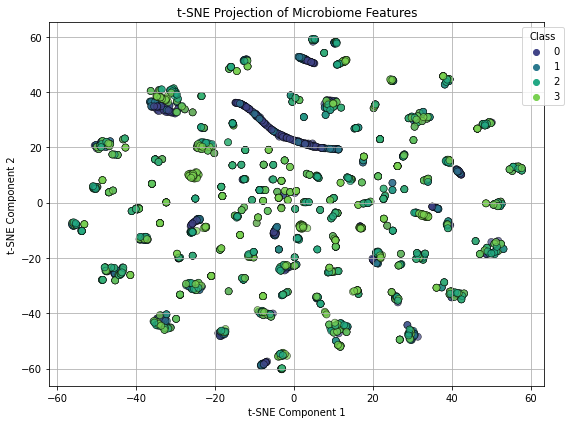

In [ ]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_df_aligned)

# Convert labels to numeric
y_numeric = train_labels.map(label_map) if not np.issubdtype(train_labels.dtype, np.number) else train_labels

# Run t-SNE
tsne = TSNE(
    n_components=2,
    perplexity=40,         
    learning_rate=200,    
    n_iter=500, 
    method='exact',   
    random_state=42,
    verbose=1
)

X_tsne = tsne.fit_transform(X_scaled)

# Plot t-SNE projection
plt.figure(figsize=(8, 6))
palette = sns.color_palette("viridis", len(np.unique(y_numeric)))
sns.scatterplot(
    x=X_tsne[:, 0], 
    y=X_tsne[:, 1], 
    hue=y_numeric, 
    palette=palette,
    alpha=0.7,
    edgecolor='k',
    s=50
)
plt.title("t-SNE Projection of Microbiome Features")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Class", loc="best", bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.tight_layout()
plt.show()


 > . The t-SNE projection captures **non-linear relationships**, grouping microbiome samples into tighter, more distinct local clusters by body site. It excels at showing local similarities but does not preserve global distances.

 > . The t-SNE plot shows **tight local clusters** of **same-class points** (indicating strong local similarity in microbiome composition).

 > . It uses the **perplexity parameter** (like a balance between local and global structure) to decide how many neighbors to consider when building the low-dimensional map.

 > . The t-SNE plot is great for visualizing **high-dimensional biological data** with subtle patterns.

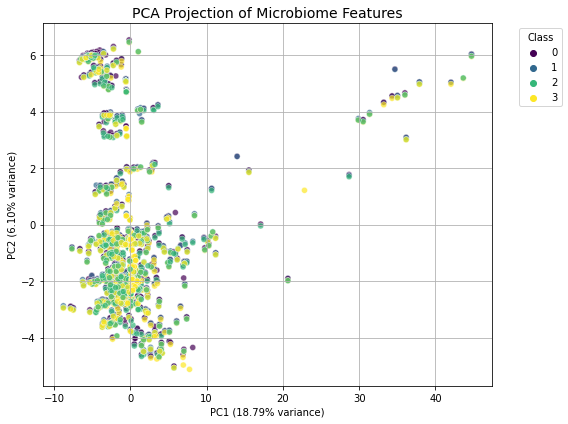

Explained variance ratio: [0.18788475 0.06100939]
Total variance explained by first 2 PCs: 24.89%


In [30]:
# PCA
pca = PCA(n_components=2)  # Project to 2D for visualization
X_pca = pca.fit_transform(X_scaled)

# Create DataFrame for plotting
pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Label': y_numeric
})

# Plot PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pca_df,
    x='PC1', y='PC2',
    hue='Label',
    palette='viridis',
    alpha=0.7
)
plt.title('PCA Projection of Microbiome Features', fontsize=14)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)")
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()
# Print variance explained
print("Explained variance ratio:", pca.explained_variance_ratio_)
print(f"Total variance explained by first 2 PCs: {pca.explained_variance_ratio_[:2].sum()*100:.2f}%")


> . PCA captures **linear relationships**, overall **variance structure** and is useful for **feature interpretability**

> . **PC1 (Principal Component 1)** captures the direction of maximum variance in the dataset; **PC2** captures the second-highest variance orthogonal to PC1

> . The points are color-coded by body site class.

> . In the plot above, the spread along PC1 and PC2 suggests there is some separation, but many points **overlap**—meaning linear projections don’t fully distinguish classes.

> . The clusters are elongated and overlapping, which is common in biological data due to **subtle differences** between microbiomes.

## **Modelling**

In [31]:
# Load Processed Data 
train_features_path = os.path.join( r".\train_processed.csv")
test_features_path = os.path.join(r".\test_processed.csv")
train_labels_path = os.path.join(r".\train_labels.csv")
sample_submission_path = os.path.join(r".\Other Files\SampleSubmission.csv")

In [32]:
# Read the processed data
X = pd.read_csv(train_features_path)
y_df = pd.read_csv(train_labels_path)
y = y_df.iloc[:, 0] # Get the first column as a Series
X_test = pd.read_csv(test_features_path)
sample_submission_df = pd.read_csv(sample_submission_path)

print(f"Training features shape: {X.shape}")
print(f"Test features shape: {X_test.shape}")


Training features shape: (2901, 157)
Test features shape: (1068, 157)


In [33]:
# Encode Target Labels 
# The target variable 'SampleType' is categorical. We need to convert it into numerical labels for the models to process.
print("Encoding target labels...")
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print(f"Encoded labels for classes: {list(label_encoder.classes_)}")


Encoding target labels...
Encoded labels for classes: ['Mouth', 'Nasal', 'Skin', 'Stool']


In [34]:
# Split Data for Validation
# We split the training data into a training set and a validation set.This allows us to evaluate our models on data they haven't seen during training.
print("Splitting data into training and validation sets...")
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")

Splitting data into training and validation sets...
Training set size: 2320
Validation set size: 581


### **RandomForestClassifier - Tuned model**


In [36]:
# Train and Evaluate RandomForest Classifier
# Define Hyperparameter Grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Setup GridSearch
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# Fit Model 
print("\n Tuning RandomForestClassifier ")
start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()
print(f"GridSearch took {(end_time - start_time)/60:.2f} minutes.")

# Best Parameters and Model 
best_rf = grid_search.best_estimator_
print(" Best Parameters Found:", grid_search.best_params_)


 Tuning RandomForestClassifier 
Fitting 3 folds for each of 48 candidates, totalling 144 fits
GridSearch took 2.68 minutes.
 Best Parameters Found: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}



Validation Set Performance (RandomForest):


Accuracy: 0.7194
Classification Report:
              precision    recall  f1-score   support

       Mouth       0.77      0.77      0.77       119
       Nasal       0.61      0.66      0.64       142
        Skin       0.82      0.83      0.83       158
       Stool       0.68      0.62      0.65       162

    accuracy                           0.72       581
   macro avg       0.72      0.72      0.72       581
weighted avg       0.72      0.72      0.72       581



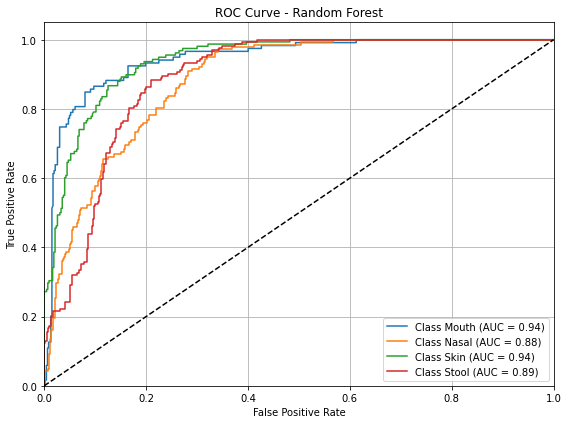

In [37]:
# Evaluate on the validation set
print("\nValidation Set Performance (RandomForest):")
rf_preds = best_rf.predict(X_val)
rf_accuracy = accuracy_score(y_val, rf_preds)
print(f"Accuracy: {rf_accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_val, rf_preds, target_names=label_encoder.classes_))

# ROC Curve and AUC 
# Binarize the output for multi-class ROC/AUC
y_val_binarized = label_binarize(y_val, classes=range(len(label_encoder.classes_)))
rf_probs = best_rf.predict_proba(X_val)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(label_encoder.classes_)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_binarized[:, i], rf_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()


>   . The tuned Random Forest model achieved an overall **accuracy** of **71.9%** on the validation set.
    
>  . Performance across classes was generally strong, with **Skin (F1 = 0.83)** and **Mouth (F1 = 0.77)** showing the highest predictive accuracy, indicating clear feature separation for these categories.

>   . **Nasal (F1 = 0.64)** had the weakest performance, suggesting greater overlap with other classes or less distinctive features.

>   . **Stool** performed fairly well **(F1 = 0.65)**

>   . The **macro-average F1-score (0.72)** and **weighted-average F1-score (0.72)** indicate that the model handles class balance reasonably well.

#### **SHAP(SHapley Additive exPlanations) Explainer**

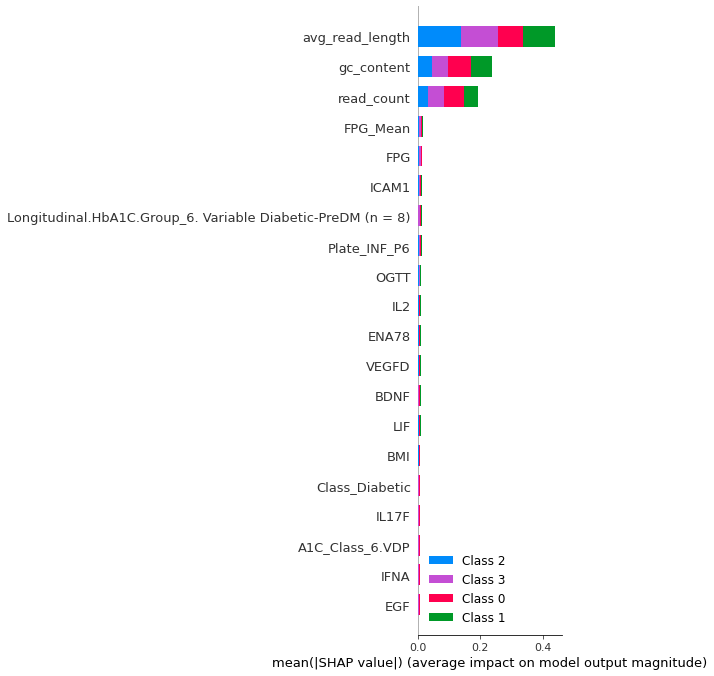

In [38]:
# Sample 1500 records to compute SHAP
X_sample = X_train.sample(n=1500, random_state=42)
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_sample)

# Plot summary
shap.summary_plot(shap_values, X_sample)


**Feature Importance (SHAP/RandomForest Plot)**

> . The plot above shows that your most influential features used by the RandomForest model in predicting microbiome sample type (Mouth, Nasal, Skin, Stool) are:

| Feature                  | Notes                                                                             |
| ------------------------ | --------------------------------------------------------------------------------- |
| **avg\_read\_length**    | Most influential — possibly reflects sequencing protocol or sample complexity. |
| **gc\_content**          | Strongly indicative of microbial composition.                                     |
| **read\_count**          | A proxy for sequencing depth, which can hint at biomass or complexity.            |
| **Adj\_age**             | Possibly reflects host factors affecting microbiome.                              |
| Others (OGTT, BMI, etc.) | Minor contributions — possibly useful in ensemble or stacked models.              |

> . Biological features (cytokines, metadata) have low influence compared to sequence-derived stats. This suggests the sequencing features carry the bulk of predictive signal.

### **XGboost - Tuned Model**

In [39]:
# Train and Evaluate XGBoost Classifier
print("Training XGBoost Classifier")
# Define the model
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',    
    cv=3,                  
    verbose=2,
    n_jobs=-1
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Best parameters and model
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

Training XGBoost Classifier
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
Best CV Score: 0.8663846463268828


Validation Set Performance (XGBoost - Tuned):
Accuracy: 0.8692
Classification Report:
              precision    recall  f1-score   support

       Mouth       0.88      0.88      0.88       119
       Nasal       0.87      0.78      0.82       142
        Skin       0.91      0.91      0.91       158
       Stool       0.82      0.90      0.86       162

    accuracy                           0.87       581
   macro avg       0.87      0.87      0.87       581
weighted avg       0.87      0.87      0.87       581



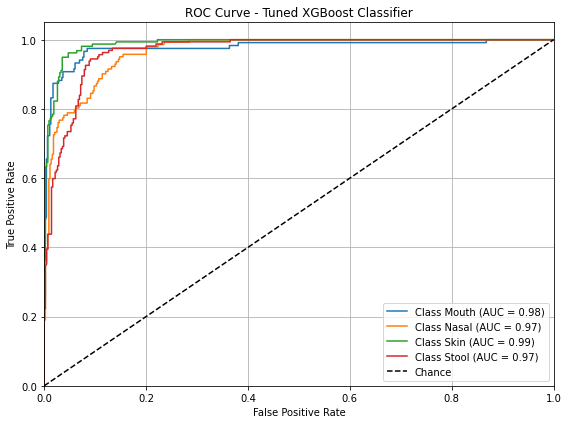

In [40]:
# Evaluate on the validation set
print("Validation Set Performance (XGBoost - Tuned):")
best_xgb = grid_search.best_estimator_
xgb_preds = best_xgb.predict(X_val)
xgb_accuracy = accuracy_score(y_val, xgb_preds)
print(f"Accuracy: {xgb_accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_val, xgb_preds, target_names=label_encoder.classes_))

# ROC and AUC evaluation 
# Binarize the labels for multiclass ROC
y_val_binarized = label_binarize(y_val, classes=range(len(label_encoder.classes_)))
xgb_probs = best_xgb.predict_proba(X_val)

fpr, tpr, roc_auc = {}, {}, {}
n_classes = len(label_encoder.classes_)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_binarized[:, i], xgb_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Tuned XGBoost Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


> . The tuned XGBoost model achieved an **accuracy** of **86.9%** on the validation set.

> . **Skin (F1 = 0.91)** and Mouth **(F1 = 0.88)** were predicted with the highest consistency.

> . **Stool (F1 = 0.86)** also performed well, benefiting from high **recall (0.90)**.

> . **Nasal (F1 = 0.82)** had slightly lower **recall (0.78)**, suggesting some misclassification with other classes, but still demonstrated robust precision. 

> .  **Macro** and **weighted averages** (**both 0.87**) confirm balanced performance across all classes, indicating that the model generalizes well without favoring a specific class.

#### **SHAP(SHapley Additive exPlanations) Explainer**

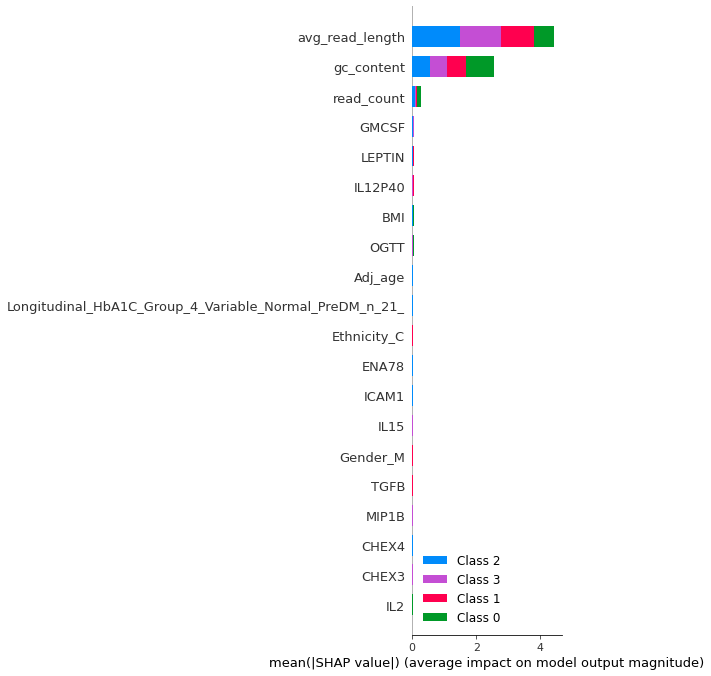

In [44]:
# Sample 1500 records to compute SHAP
X_sample = X_train.sample(n=1500, random_state=42)
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_sample)

# Plot summary
shap.summary_plot(shap_values, X_sample)


**Feature Importance (SHAP/XGBoost Plot)**

> . The plot above shows that your most influential features used by the XGBoost model in predicting microbiome sample type (Mouth, Nasal, Skin, Stool) are:

| Feature                  | Notes                                                                             |
| ------------------------ | --------------------------------------------------------------------------------- |
| **avg\_read\_length**    | Most influential — possibly reflects sequencing protocol or sample complexity. |
| **gc\_content**          | Strongly indicative of microbial composition.                                     |
| **read\_count**          | A proxy for sequencing depth, which can hint at biomass or complexity.            |
| **Adj\_age**             | Possibly reflects host factors affecting microbiome.                              |
| Others (OGTT, BMI, etc.) | Minor contributions — possibly useful in ensemble or stacked models.              |

> . Biological features (cytokines, metadata) have low influence compared to sequence-derived stats. This suggests the sequencing features carry the bulk of predictive signal.

### **LightGBM Classifier - Tuned**

In [41]:
# Function to clean column names 
def clean_column_names(df):
    df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
    return df

X_train = clean_column_names(X_train)
X_val = clean_column_names(X_val)

# Base LightGBM Model
lgb_base = lgb.LGBMClassifier(
    random_state=42,
    n_jobs=-1
)

# Parameter Grid for Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 63, 127],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# GridSearchCV
grid_search = GridSearchCV(
    estimator=lgb_base,
    param_grid=param_grid,
    scoring='accuracy', 
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Best Parameters and Model
best_lgb = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

Fitting 3 folds for each of 324 candidates, totalling 972 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17137
[LightGBM] [Info] Number of data points in the train set: 2320, number of used features: 142
[LightGBM] [Info] Start training from score -1.588115
[LightGBM] [Info] Start training from score -1.407201
[LightGBM] [Info] Start training from score -1.305191
[LightGBM] [Info] Start training from score -1.273890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 31, 'subsample': 0.8}
Best CV Score: 0.8590533431834313


### **Evaluation**

Validation Set Performance (LightGBM - Tuned):
Accuracy: 0.8640
Classification Report:
              precision    recall  f1-score   support

       Mouth       0.87      0.86      0.86       119
       Nasal       0.87      0.79      0.83       142
        Skin       0.89      0.91      0.90       158
       Stool       0.83      0.90      0.86       162

    accuracy                           0.86       581
   macro avg       0.87      0.86      0.86       581
weighted avg       0.86      0.86      0.86       581



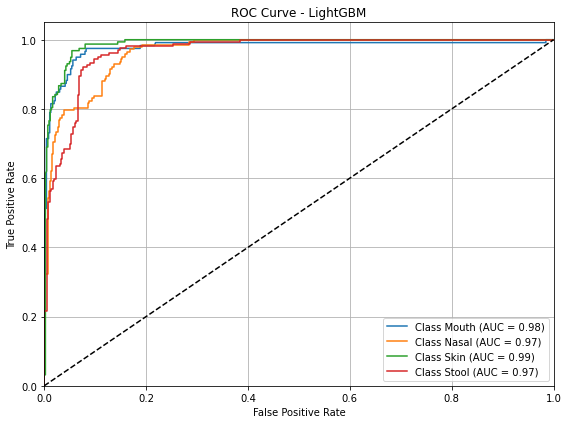

In [42]:
# Evaluate on the validation set
print("Validation Set Performance (LightGBM - Tuned):")
lgb_preds = best_lgb.predict(X_val)
lgb_accuracy = accuracy_score(y_val, lgb_preds)
print(f"Accuracy: {lgb_accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_val, lgb_preds, target_names=label_encoder.classes_))

# ROC Curve and AUC 
# Binarize the output for multi-class ROC AUC
y_val_binarized = label_binarize(y_val, classes=range(len(label_encoder.classes_)))
lgb_probs = best_lgb.predict_proba(X_val)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(label_encoder.classes_)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_binarized[:, i], lgb_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LightGBM')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()

>  . The tuned LightGBM model achieved an **accuracy** of **86.4%**

>  . **Skin (F1 = 0.90)** had the highest performance with excellent **recall (0.91)**

>  . **Mouth (F1 = 0.87)** and **Stool (F1 = 0.86)** also showed **balanced precision** and **recall**

>  . **Nasal (F1 = 0.83)** again had **slightly lower recall (0.79)**, indicating occasional confusion with other classes

>  .  **Macro** and **weighted** averages **(0.86–0.87)** confirm balanced predictions across all categories, with no strong bias toward a single class

#### **SHAP(SHapley Additive exPlanations) Explainer**

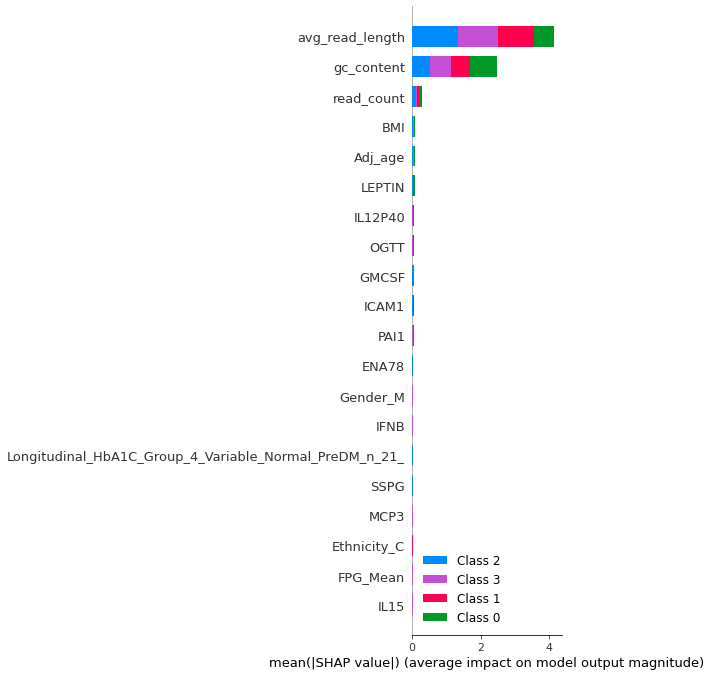

In [43]:
# Sample 1500 records to compute SHAP
X_sample = X_train.sample(n=1500, random_state=42)
explainer = shap.TreeExplainer(best_lgb)
shap_values = explainer.shap_values(X_sample)

# Plot summary
shap.summary_plot(shap_values, X_sample)


**Feature Importance (SHAP/LighGBM Plot)**

 > . The plot above shows that your most influential features used by the model(LightGBM - Tuned) in predicting microbiome sample type (Mouth, Nasal, Skin, Stool) are:

| Feature                  | Notes                                                                             |
| ------------------------ | --------------------------------------------------------------------------------- |
| **avg\_read\_length**    | Most influential — possibly reflects sequencing protocol or sample complexity. |
| **gc\_content**          | Strongly indicative of microbial composition.                                     |
| **read\_count**          | A proxy for sequencing depth, which can hint at biomass or complexity.            |
| **Adj\_age**             | Possibly reflects host factors affecting microbiome.                              |
| Others (OGTT, BMI, etc.) | Minor contributions — possibly useful in ensemble or stacked models.              |


 > . Biological features (cytokines, metadata) have low influence compared to sequence-derived stats. This suggests the sequencing features carry the bulk of predictive signal.

### **Save Best Model**

In [ ]:
import joblib

# Save model
joblib.dump(best_xgb, "xgboost_tuned_model.pkl")
print(" Tuned XGBoost model saved as 'xgboost_tuned_model.pkl'")


 Tuned XGBoost model saved as 'xgboost_tuned_model.pkl'


## **Deployment**

 >  . We have reached the final step of the project, Here we will deploy our **tuned XGBoost model** using **Gradio**, a Python library that allows us to quickly build interactive and visually appealing web apps for ML models.

In [60]:
# Import necessary libraries for Gradio and LIME
import gradio as gr
import joblib
from lime.lime_tabular import LimeTabularExplainer
import tempfile
import os

# Load Model & Prepare feature names and class names
model = joblib.load("xgboost_tuned_model.pkl")
feature_names = X_train.columns.tolist() 
class_names = model.classes_.tolist()

# Top & Extra Features 
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

TOP_N = 10
top_features = importance_df.head(TOP_N)['feature'].tolist()
extra_features = [f for f in feature_names if f not in top_features]

# LIME Explainer 
explainer = LimeTabularExplainer(
    training_data=np.array(X_train[top_features + extra_features]),
    feature_names=top_features + extra_features,
    class_names=class_names,
    mode="classification"
)

# Predict & Explain Function 
def predict_and_explain(*args):
    # Unpack flattened args
    top_inputs = args[:len(top_features)]
    use_extra = args[len(top_features)]
    extra_inputs = args[len(top_features)+1:]

    # Build input dict
    feature_input = {feat: val for feat, val in zip(top_features, top_inputs)}
    if use_extra:
        feature_input.update({feat: val for feat, val in zip(extra_features, extra_inputs)})
    else:
        feature_input.update({feat: 0 for feat in extra_features})
    
    input_df = pd.DataFrame([feature_input])

    # Predict
    probs = model.predict_proba(input_df)[0]
    pred_class = class_names[np.argmax(probs)]

    # Probability Chart
    fig, ax = plt.subplots(figsize=(5, 4))
    colors = ['lightgray'] * len(class_names)
    colors[np.argmax(probs)] = 'skyblue'
    sns.barplot(x=probs, y=class_names, palette=colors, ax=ax)
    ax.set_xlim(0, 1)
    ax.set_xlabel("Probability")
    ax.set_title("Prediction Probabilities")
    plt.tight_layout()
    prob_chart_path = os.path.join(tempfile.gettempdir(), "prob_chart.png")
    plt.savefig(prob_chart_path)
    plt.close(fig)

    # LIME Explanation
    exp = explainer.explain_instance(
        data_row=input_df.values[0],
        predict_fn=model.predict_proba,
        num_features=TOP_N
    )
    lime_html_path = os.path.join(tempfile.gettempdir(), "lime_explanation.html")
    exp.save_to_file(lime_html_path)
    with open(lime_html_path, "r", encoding="utf-8") as f:
        lime_html = f.read()
    lime_html_iframe = f"""
    <iframe srcdoc='{lime_html.replace("'", "&apos;")}' 
            width="100%" height="500px" style="border:none;"></iframe>
    """

    return pred_class, prob_chart_path, lime_html_iframe

# Gradio UI 
with gr.Blocks(theme=gr.themes.Soft()) as demo:
    # Title
    gr.HTML("""
    <div style="text-align: center; padding: 15px; 
                background: linear-gradient(90deg, #2c5364, #203a43, #0f2027); 
                color: white; border-radius: 10px;">
        <h1>🧬 Microbiome Sample Classifier</h1>
        <p>Powered by Tuned <b>XGBoost</b> with Interactive <b>LIME Explainability</b></p>
    </div>
    """)

    with gr.Row():
        with gr.Column(scale=1):
            gr.Markdown("### ✏️ Enter Top Feature Values")
            top_inputs = [gr.Number(label=feat) for feat in top_features]

            gr.Markdown("### ⚙️ Additional Features (Optional)")
            use_extra = gr.Checkbox(label="Enable Additional Features", value=False)
            extra_inputs = [gr.Number(label=feat, visible=False) for feat in extra_features]

            def toggle_extra(enable):
                return [gr.update(visible=enable) for _ in extra_inputs]
            use_extra.change(fn=toggle_extra, inputs=use_extra, outputs=extra_inputs)

            predict_btn = gr.Button("🚀 Predict", variant="primary")

        with gr.Column(scale=2):
            with gr.Tabs():
                with gr.Tab("📊 Prediction Results"):
                    output_label = gr.Label(label="Predicted Class")
                    output_chart = gr.Image(label="Class Probabilities")
                with gr.Tab("🧠 LIME Explanation"):
                    output_lime = gr.HTML(label="LIME Explanation")

    # Flattened inputs 
    predict_btn.click(
        fn=predict_and_explain,
        inputs=top_inputs + [use_extra] + extra_inputs,
        outputs=[output_label, output_chart, output_lime]
    )

# Launch the Gradio app
demo.launch(share = True )


Running on local URL:  http://127.0.0.1:7863
Running on public URL: https://42307830adcb1effd2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## **Conclusion**

   >. This project successfully developed a microbiome sample classification system capable of accurately predicting sample sources (Mouth, Nasal, Skin, Stool) using advanced machine learning techniques.

   >. After evaluating multiple models — including Random Forest, LightGBM, and XGBoost — the tuned XGBoost classifier achieved the best performance, with an accuracy of 86.9% and balanced precision, recall, and F1-scores across all classes. The model’s high predictive power, combined with interactive LIME explainability, ensures transparency and interpretability of predictions, making it suitable for practical deployment.

   >. The integration of an interactive Gradio web application further enhances usability, allowing non-technical stakeholders to easily run predictions, visualize class probabilities, and understand model reasoning.

   >. This pipeline demonstrates the value of combining robust modeling with explainability to support evidence-based decision-making in microbiome research and diagnostics.